In [52]:
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt

m = GEKKO(remote = False)


#initialize variables

#Room Temprature:
T_external = [23,23,23,23,23.5,23.5,23.4,23.5,23.9,23.7,\
              23,23.9,23.9,23.4,23.9,24,23.6,23.7,23.8,\
              23,23,23,23,23]

# Temprature Lower Limit:
temp_low = 10*np.ones(24)

# Temprature Upper Limit:
temp_upper = 12*np.ones(24)

#Hourly Energy prices:
TOU_v = [39.09,34.93,38.39,40.46,40.57,43.93,25,11,9,24,51.28,45.22,45.72,\
            36,35.03,10,12,13,32.81,42.55,8,29.58,29.52,29.52]

###########################################
#System Identification:

#Time 
t = np.linspace(0,10,117)
#State of the Fridge
ud = np.append(np.zeros(78) ,np.ones(39),0)
#Temprature Data for 10 min 
y = [14.600000000000001,14.600000000000001,14.700000000000001,14.700000000000001,14.700000000000001,\
     14.700000000000001,14.700000000000001,14.700000000000001,14.700000000000001,14.700000000000001,\
     14.700000000000001,14.700000000000001,14.700000000000001,14.8,14.8,14.8,14.8,14.8,14.8,14.8,14.8,\
    14.8,14.8,14.9,14.9,14.9,14.9,14.9,14.9,14.9,15,15,15,15,15,15,15,15,15,15,15,15,15.100000000000001,\
    15.100000000000001,15.100000000000001,15.100000000000001,15.100000000000001,15.100000000000001,\
    15.100000000000001,15.100000000000001,15.100000000000001,15.100000000000001,15.100000000000001,\
    15.100000000000001,15.100000000000001,15.100000000000001,15.100000000000001,15.100000000000001,\
    15.100000000000001,15.100000000000001,15.100000000000001,15.100000000000001,15.100000000000001,\
    15.100000000000001,15.100000000000001,15.100000000000001,15.100000000000001,15.100000000000001,\
    15.100000000000001,15.100000000000001,15.100000000000001,15.100000000000001,15.100000000000001,\
    15.100000000000001,15.100000000000001,15.100000000000001,15.100000000000001,15.100000000000001,
    15,15,15,15,15,15,15,15,15,15,14.9,14.9,14.9,14.9,14.8,14.9,14.8,14.8,14.8,14.8,14.8,14.8,\
    14.8,14.700000000000001,14.8,14.700000000000001,14.700000000000001,14.700000000000001,\
    14.700000000000001,14.700000000000001,14.700000000000001,14.700000000000001,\
    14.700000000000001,14.600000000000001,14.600000000000001,14.600000000000001,\
    14.600000000000001,14.600000000000001,14.60]

na = 1 # output coefficients
nb = 1 # input coefficients
print('Identification')
yp,p,K = m.sysid(t,ud,y,na,nb,objf=10000,scale=False,diaglevel=1)
print(p)
#create control ARX model:


Identification
 ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            2
   Constants    :            6
   Variables    :          358
   Intermediates:            0
   Connections  :            4
   Equations    :          236
   Residuals    :          236
 
 Number of state variables:            122
 Number of total equations: -          119
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              3
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Model Parameter Estimation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  3.99024E+03  9.53537E-01
    1  1.63035E+03  2.

 ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            1
   Constants    :            0
   Variables    :            8
   Intermediates:            0
   Connections  :            2
   Equations    :            3
   Residuals    :            3
 
 Number of state variables:            943
 Number of total equations: -          920
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :             23
 
 ----------------------------------------------
 Dynamic Control with APOPT Solver
 ----------------------------------------------
Iter:     1 I:  0 Tm:      0.04 NLPi:    5 Dpth:    0 Lvs:    0 Obj:  3.53E+04 Gap:  0.00E+00
 Successful solution
 
 ---------------------------------------------------
 Solver  

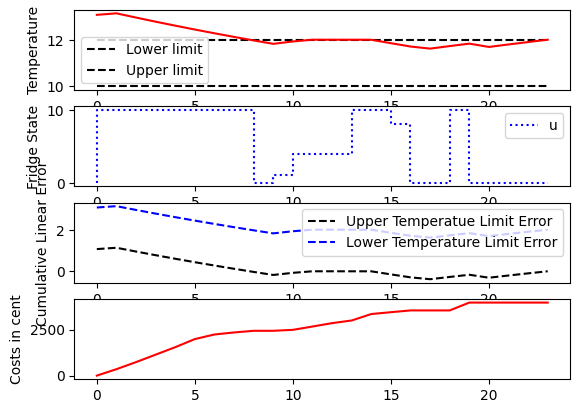

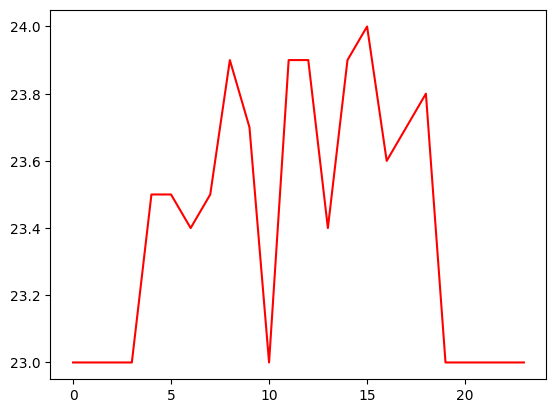

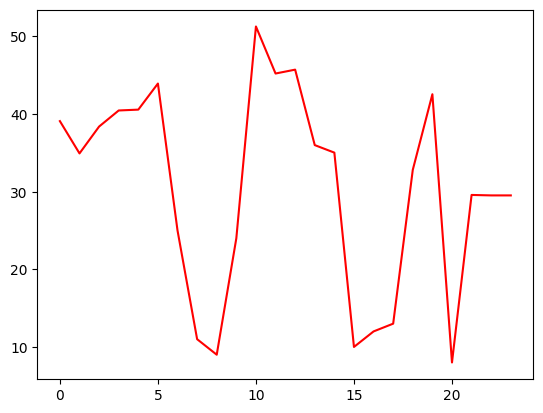

In [53]:

# Controlled variable:
T = m.CV()
# Manipulated variable:
u = m.MV(value=0,lb=0, ub=10, integer=True)
# Create ARX Model
m.arx(p,T,u)

###########################################

#Parameter
P = m.Param(value =100) #power
TL = m.Param(value=temp_low[0]) 
TH = m.Param(value=temp_upper[0])
c = m.Param(value=TOU_v[0])

u.STATUS = 1  # allow optimizer to change the variable to attein the optimum.

# Controlled Variable (Affected with changes in the manipulated variable)
#T = m.CV()
# Soft constraints on temprature.

eH = m.CV(value=0)
eL = m.CV(value=0)

eH.SPHI=0         #Set point high for linear error model.
eH.WSPHI=1000000000     #Objective function weight on upper set point for linear error model.
eH.WSPLO=0        # Objective function weight on lower set point for linear error model
eH.STATUS =1      # eH : Error is considered in the objective function.

eL.SPLO=0
eL.WSPHI=0
eL.WSPLO=1000
eL.STATUS = 1   
#Linear error (Deviation from the limits)
m.Equations([eH==T-TH,eL==T-TL])

#Objective: minimize costs.
m.Minimize(c*P*u)

#Optimizer Options.

# steady state initialization
m.options.IMODE = 1
m.solve(disp=False)

TL.value = temp_low
TH.value = temp_upper
#TH.UPPER = 12
c.value  = TOU_v
T.value = 13 # Temprature starts at 11

#Set Up MPC
m.options.IMODE = 6 # MPC mode in Gekko.
m.options.NODES = 2  # Collocation nodes.
m.options.SOLVER = 1 # APOT solver for mixed integer linear programming.
m.time = np.linspace(0,23,24)

#Solve the optimization problem.

m.solve()
m.solve() 


#Calculate the costs.
c= 0
cost_list = []
for i in range(0,len(u)):
    c = c + TOU_v[i]*u[i]
    cost_list.append(c)
print('The daily energy cost is' ,c/100, 'Euro') 

plt.subplot(4,1,1)
plt.plot(m.time,temp_low,'k--', label='Lower limit')
plt.plot(m.time,temp_upper,'k--',label='Upper limit')
plt.plot(m.time,T.value,'r-')
plt.ylabel('Temperature')
plt.legend()
plt.subplot(4,1,2)
plt.step(m.time,u.value,'b:',label='u')
plt.ylabel('Fridge State')
#plt.grid()
plt.legend()
plt.subplot(4,1,3)
plt.plot(m.time, eH.value, 'k--', label='Upper Temperatue Limit Error')
plt.plot(m.time, eL.value, 'b--', label='Lower Temperature Limit Error')
plt.ylabel('Cumulative Linear Error')
plt.legend()
plt.subplot(4,1,4)
plt.plot(m.time, cost_list, 'r-')
plt.ylabel('Costs in cent')
plt.show()
plt.plot(m.time, T_external, 'r-')
plt.show()
plt.plot(m.time, TOU_v, 'r-')